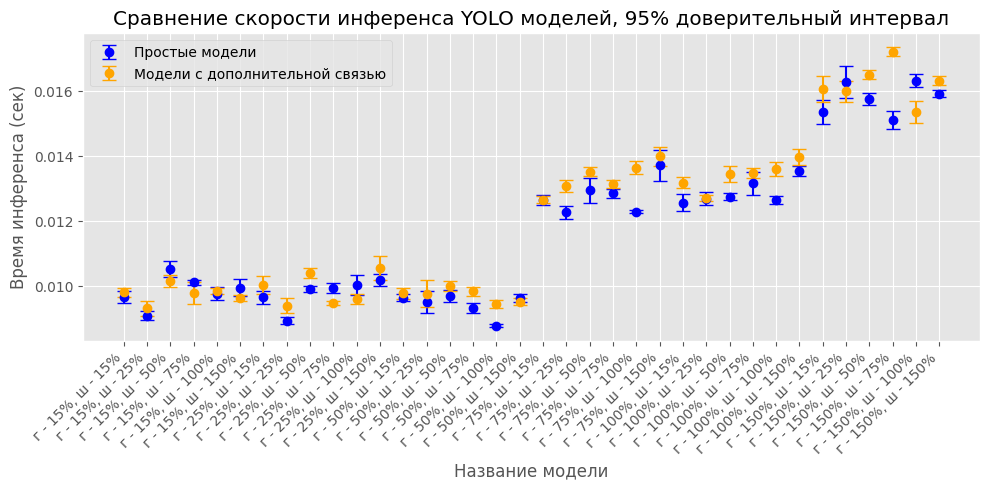

In [390]:
import time
import os
import re
import torch
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
from PIL import Image
import torchvision.transforms as T
from scipy import stats
from torchvision.models.detection import fasterrcnn_resnet50_fpn, ssd300_vgg16
from detection_model import ObjectDetectionModel
from collections import defaultdict
# Базовый размер модели YOLO
base_yolo_size = [0.50, 0.25]

def extract_model_size(folder_name):
    """Извлекает параметры depth и width из названия папки в формате [depth_xx-width_xx] и переводит в формат 'г - n%, ш - k%'"""
    extra_flag = 'base'
    if folder_name.startswith('extra13_'):
        extra_flag = 'extra13_'
        folder_name = folder_name.replace('extra13_', '')
        #folder_name = folder_name[6:] #удаляем extra_
    depth, width = folder_name.replace('[depth_', '').replace(']', '').replace('-width_', ' ').split(' ')
     
    depth, width = float(depth) , float(width)  
    # Переводим в проценты относительно базового размера
    depth_percent = (depth  ) * 100
    width_percent = (width ) * 100
    return extra_flag, f"г - {int(depth_percent)}%, ш - {int(width_percent)}%" 
    match = re.search(r"\[depth_(\d+\.\d+)-width_(\d+\.\d+)\]", folder_name)
    if match:
        depth = float(match.group(1)) * 100
        width = float(match.group(2)) * 100

        # Переводим в проценты относительно базового размера
        depth_percent = (float(match.group(1)) / base_yolo_size[0]) * 100
        width_percent = (float(match.group(2)) / base_yolo_size[1]) * 100

        return f"г - {int(depth_percent)}%, ш - {int(width_percent)}%"
    return None

def measure_inference_time(model_path, image, num_runs=200, mode='yolo'):
    """Измеряет время инференса модели YOLO, возвращает список времен инференса"""
    if mode == 'yolo':
        model = YOLO(model_path)
        inference_times = []
        
        # Прогоняем инференс num_runs раз
        for i in range(num_runs):
            start_time = time.time()
            _ = model(image.unsqueeze(0), verbose=False)  # Запуск инференса
            end_time = time.time()

            if i > 0:  # Пропускаем первый запуск
                inference_times.append(end_time - start_time)

        return inference_times  # Возвращаем все времена инференса

    inference_times = []
    for i in range(num_runs):
        start_time = time.time()
        _ = model_path([image])  # Запуск инференса
        end_time = time.time()

        if i > 0:  # Пропускаем первый запуск
            inference_times.append(end_time - start_time)

    return inference_times

def evaluate_models(logs_dir, image_path, num_runs=250, extra_measure = False):
    """Проверяет скорость инференса всех моделей в logs_dir и строит график сравнения"""
    to_tensor = T.ToTensor()
    # Загружаем изображение
    image = Image.open(image_path).convert("RGB")
    image_custom = image.resize((576, 576)) 
    image_custom = to_tensor(image_custom) 
    #results = {} 
    # Инициализируем defaultdict с вложенным defaultdict
    results = defaultdict(lambda: defaultdict(dict))
    # Перебираем папки с моделями
    for folder in sorted(os.listdir(logs_dir)):
        if folder.startswith('extra_'): continue
        folder_path = os.path.join(logs_dir, folder)
        if not os.path.isdir(folder_path):
            continue
        
        extra_flag, model_name = extract_model_size(folder)
        if not model_name:
            continue  # Пропускаем папки без соответствующего формата

        weights_path = os.path.join(folder_path, "weights", "best.pt")
        if os.path.exists(weights_path):
            # Измеряем инференс для модели
            inference_times = measure_inference_time(weights_path, image_custom, num_runs) 
            # Рассчитываем доверительный интервал для инференса
            confidence_interval = stats.t.interval(0.95, len(inference_times)-1, loc=np.mean(inference_times), scale=stats.sem(inference_times))
            
            results[model_name][extra_flag] = {
                'mean': np.mean(inference_times),
                'ci_lower': confidence_interval[0],
                'ci_upper': confidence_interval[1],
                'inference_times': inference_times
            }
    if extra_measure: 
        for model_path in [['../detection/logs/ssd300/checkpoints/epoch=16-val_mAP=0.4295.ckpt', ssd300_vgg16, 'SSD'], 
                           ['../detection/logs/mask_rcnn/checkpoints/epoch=05-val_mAP=0.3417.ckpt', fasterrcnn_resnet50_fpn, 'FasterRCNN']]: 
            # Загружаем модель
            model = ObjectDetectionModel.load_from_checkpoint(model_path[0], 'cpu')
            model.eval() 
            inference_times = measure_inference_time(model, image_custom, num_runs, mode = 'not yolo')
            confidence_interval = stats.t.interval(0.95, len(inference_times)-1, loc=np.mean(inference_times), scale=stats.sem(inference_times))
            
            results[model_path[2]]['base'] = {
                'mean': np.mean(inference_times),
                'ci_lower': confidence_interval[0],
                'ci_upper': confidence_interval[1],
                'inference_times': inference_times
            }
            
            
            
              
    # Построение графика с доверительными интервалами
    fig, ax = plt.subplots(figsize=(10, 5))
    # Стиль графика
    plt.style.use("ggplot")   
    ax.set_title("Сравнение скорости инференса YOLO моделей, 95% доверительный интервал")
    ax.set_xlabel("Название модели")
    ax.set_ylabel("Время инференса (сек)")

    # Преобразуем данные для построения
    model_names = list(results.keys())
    #extra_model_names = list(results['extra'].keys())
    #mean_times = [results[model]['base']['mean'] for model in base_model_names]
    #ci_lowers = [results[model]['base']['ci_lower'] for model in base_model_names]
    #ci_uppers = [results[model]['base']['ci_upper'] for model in base_model_names]
    
    # Подготовка данных для графика
    x_pos = np.arange(len(model_names))  # Позиции по оси X для каждой модели
    means_base = []  # Список средних значений для base
    ci_lower_base = []  # Список нижних границ доверительного интервала для base
    ci_upper_base = []  # Список верхних границ доверительного интервала для base
    
    means_extra = []  # Список средних значений для extra
    ci_lower_extra = []  # Список нижних границ доверительного интервала для extra
    ci_upper_extra = []  # Список верхних границ доверительного интервала для extra
    # Обрабатываем каждую модель
    for i, model_name in enumerate(model_names):
        # Проверяем, есть ли данные для base
        base_data = results[model_name].get('base', None)
        if base_data:
            means_base.append(base_data['mean'])
            ci_lower_base.append(base_data['ci_lower'])
            ci_upper_base.append(base_data['ci_upper'])

        # Проверяем, есть ли данные для extra
        extra_data = results[model_name].get('extra13_', None)
        if extra_data:
            means_extra.append(extra_data['mean'])
            ci_lower_extra.append(extra_data['ci_lower'])
            ci_upper_extra.append(extra_data['ci_upper'])

    # Строим график для base
    ax.errorbar(x_pos, means_base, yerr=[np.array(means_base) - np.array(ci_lower_base), 
                                         np.array(ci_upper_base) - np.array(means_base)],
                fmt='o', label='Простые модели', color='blue', capsize=5, linestyle='none')

    # Строим график для extra, если данные есть
    if means_extra and not extra_measure:
        ax.errorbar(x_pos[:len(means_extra)], means_extra, yerr=[np.array(means_extra) - np.array(ci_lower_extra), 
                                               np.array(ci_upper_extra) - np.array(means_extra)],
                    fmt='o', label='Модели с дополнительной связью', color='orange', capsize=5, linestyle='none')

    # Настроим ось X
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_names, rotation=45, ha='right')

    # Добавляем легенду
    ax.legend()
    
    
    
    
    # Строим точки с доверительным интервалом
    #ax.errorbar(base_model_names, mean_times, yerr=[np.array(mean_times) - np.array(ci_lowers), np.array(ci_uppers) - np.array(mean_times)],
    #            fmt='o', color='b', capsize=5)
    #mean_times = [results[model]['extra']['mean'] for model in extra_model_names]
    #ci_lowers = [results[model]['extra']['ci_lower'] for model in extra_model_names]
    #ci_uppers = [results[model]['extra']['ci_upper'] for model in extra_model_names]
    # Строим точки с доверительным интервалом
    #ax.errorbar(extra_model_names, mean_times, yerr=[np.array(mean_times) - np.array(ci_lowers), np.array(ci_uppers) - np.array(mean_times)],
    #            fmt='o', color='r', capsize=5) 
    # Настроим ось X
    #ax.set_xticklabels(base_model_names, rotation=45, ha='right')
    
    # Показать график
    plt.tight_layout()
    plt.show()

    # Вывод результатов
    #for model, data in results.items():
    #    print(f"{model}: {data['mean']:.4f} сек, доверительный интервал: ({data['ci_lower']:.4f}, {data['ci_upper']:.4f})")

# Пути
logs_dir = "../detection/logs/yolo11/"
image_path = "1.jpg"

# Запуск
evaluate_models(logs_dir, image_path, num_runs=300, extra_measure = False)

In [ ]:
import time
import os
import re
import torch
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
from PIL import Image
import torchvision.transforms as T
from scipy import stats
from torchvision.models.detection import fasterrcnn_resnet50_fpn, ssd300_vgg16
from detection_model import ObjectDetectionModel
from collections import defaultdict
# Базовый размер модели YOLO
base_yolo_size = [0.50, 0.25]

def extract_model_size(folder_name):
    """Извлекает параметры depth и width из названия папки в формате [depth_xx-width_xx] и переводит в формат 'г - n%, ш - k%'"""
    extra_flag = 'base'
    if folder_name.startswith('extra_'):
        extra_flag = 'extra'
        folder_name = folder_name[6:] #удаляем extra_
    depth, width = folder_name.replace('[depth_', '').replace(']', '').replace('-width_', ' ').split(' ')
     
    depth, width = float(depth) , float(width)  
    # Переводим в проценты относительно базового размера
    depth_percent = (depth  ) * 100
    width_percent = (width ) * 100
    return extra_flag, f"г - {int(depth_percent)}%, ш - {int(width_percent)}%" 
    match = re.search(r"\[depth_(\d+\.\d+)-width_(\d+\.\d+)\]", folder_name)
    if match:
        depth = float(match.group(1)) * 100
        width = float(match.group(2)) * 100

        # Переводим в проценты относительно базового размера
        depth_percent = (float(match.group(1)) / base_yolo_size[0]) * 100
        width_percent = (float(match.group(2)) / base_yolo_size[1]) * 100

        return f"г - {int(depth_percent)}%, ш - {int(width_percent)}%"
    return None

def measure_inference_time(model_path, image, num_runs=200, mode='yolo'):
    """Измеряет время инференса модели YOLO, возвращает список времен инференса"""
    if mode == 'yolo':
        model = YOLO(model_path)
        inference_times = []
        
        # Прогоняем инференс num_runs раз
        for i in range(num_runs):
            start_time = time.time()
            _ = model(image.unsqueeze(0), verbose=False)  # Запуск инференса
            end_time = time.time()

            if i > 0:  # Пропускаем первый запуск
                inference_times.append(end_time - start_time)

        return inference_times  # Возвращаем все времена инференса

    inference_times = []
    for i in range(num_runs):
        start_time = time.time()
        _ = model_path([image])  # Запуск инференса
        end_time = time.time()

        if i > 0:  # Пропускаем первый запуск
            inference_times.append(end_time - start_time)

    return inference_times

def evaluate_models(logs_dir, image_path, num_runs=250, extra_measure = False):
    """Проверяет скорость инференса всех моделей в logs_dir и строит график сравнения"""
    to_tensor = T.ToTensor()
    # Загружаем изображение
    image = Image.open(image_path).convert("RGB")
    image_custom = image.resize((576, 576)) 
    image_custom = to_tensor(image_custom) 
    #results = {} 
    # Инициализируем defaultdict с вложенным defaultdict
    results = defaultdict(lambda: defaultdict(dict))
    # Перебираем папки с моделями
    for folder in sorted(os.listdir(logs_dir)):
        if folder.startswith('extra'): continue
        folder_path = os.path.join(logs_dir, folder)
        if not os.path.isdir(folder_path):
            continue
        
        extra_flag, model_name = extract_model_size(folder)
        if not model_name:
            continue  # Пропускаем папки без соответствующего формата

        weights_path = os.path.join(folder_path, "weights", "best.pt")
        if os.path.exists(weights_path):
            # Измеряем инференс для модели
            inference_times = measure_inference_time(weights_path, image_custom, num_runs) 
            # Рассчитываем доверительный интервал для инференса
            confidence_interval = stats.t.interval(0.95, len(inference_times)-1, loc=np.mean(inference_times), scale=stats.sem(inference_times))
            
            results[model_name][extra_flag] = {
                'mean': np.mean(inference_times),
                'ci_lower': confidence_interval[0],
                'ci_upper': confidence_interval[1],
                'inference_times': inference_times
            }
    if extra_measure: 
        for model_path in [['../detection/logs/ssd300/checkpoints/epoch=16-val_mAP=0.4295.ckpt', ssd300_vgg16, 'SSD'], 
                           ['../detection/logs/mask_rcnn/checkpoints/epoch=05-val_mAP=0.3417.ckpt', fasterrcnn_resnet50_fpn, 'FasterRCNN']]: 
            # Загружаем модель
            model = ObjectDetectionModel.load_from_checkpoint(model_path[0], 'cpu')
            model.eval() 
            inference_times = measure_inference_time(model, image_custom, num_runs, mode = 'not yolo')
            confidence_interval = stats.t.interval(0.95, len(inference_times)-1, loc=np.mean(inference_times), scale=stats.sem(inference_times))
            
            results[model_path[2]]['base'] = {
                'mean': np.mean(inference_times),
                'ci_lower': confidence_interval[0],
                'ci_upper': confidence_interval[1],
                'inference_times': inference_times
            }
            
            
            
              
    # Построение графика с доверительными интервалами
    fig, ax = plt.subplots(figsize=(10, 5))
    # Стиль графика
    plt.style.use("ggplot")   
    ax.set_title("Сравнение скорости инференса YOLO моделей, 95% доверительный интервал")
    ax.set_xlabel("Название модели")
    ax.set_ylabel("Время инференса (сек)")

    # Преобразуем данные для построения
    model_names = list(results.keys())
    #extra_model_names = list(results['extra'].keys())
    #mean_times = [results[model]['base']['mean'] for model in base_model_names]
    #ci_lowers = [results[model]['base']['ci_lower'] for model in base_model_names]
    #ci_uppers = [results[model]['base']['ci_upper'] for model in base_model_names]
    
    # Подготовка данных для графика
    x_pos = np.arange(len(model_names))  # Позиции по оси X для каждой модели
    means_base = []  # Список средних значений для base
    ci_lower_base = []  # Список нижних границ доверительного интервала для base
    ci_upper_base = []  # Список верхних границ доверительного интервала для base
    
    means_extra = []  # Список средних значений для extra
    ci_lower_extra = []  # Список нижних границ доверительного интервала для extra
    ci_upper_extra = []  # Список верхних границ доверительного интервала для extra
    # Обрабатываем каждую модель
    for i, model_name in enumerate(model_names):
        # Проверяем, есть ли данные для base
        base_data = results[model_name].get('base', None)
        if base_data:
            means_base.append(base_data['mean'])
            ci_lower_base.append(base_data['ci_lower'])
            ci_upper_base.append(base_data['ci_upper'])

        # Проверяем, есть ли данные для extra
        extra_data = results[model_name].get('extra', None)
        if extra_data:
            means_extra.append(extra_data['mean'])
            ci_lower_extra.append(extra_data['ci_lower'])
            ci_upper_extra.append(extra_data['ci_upper'])

    # Строим график для base
    ax.errorbar(x_pos, means_base, yerr=[np.array(means_base) - np.array(ci_lower_base), 
                                         np.array(ci_upper_base) - np.array(means_base)],
                fmt='o', label='Простые модели', color='blue', capsize=5, linestyle='none')

    # Строим график для extra, если данные есть
    if means_extra and not extra_measure:
        ax.errorbar(x_pos[:len(means_extra)], means_extra, yerr=[np.array(means_extra) - np.array(ci_lower_extra), 
                                               np.array(ci_upper_extra) - np.array(means_extra)],
                    fmt='o', label='Модели с дополнительной связью', color='orange', capsize=5, linestyle='none')

    # Настроим ось X
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_names, rotation=45, ha='right')

    # Добавляем легенду
    ax.legend()
    
    
    
    
    # Строим точки с доверительным интервалом
    #ax.errorbar(base_model_names, mean_times, yerr=[np.array(mean_times) - np.array(ci_lowers), np.array(ci_uppers) - np.array(mean_times)],
    #            fmt='o', color='b', capsize=5)
    #mean_times = [results[model]['extra']['mean'] for model in extra_model_names]
    #ci_lowers = [results[model]['extra']['ci_lower'] for model in extra_model_names]
    #ci_uppers = [results[model]['extra']['ci_upper'] for model in extra_model_names]
    # Строим точки с доверительным интервалом
    #ax.errorbar(extra_model_names, mean_times, yerr=[np.array(mean_times) - np.array(ci_lowers), np.array(ci_uppers) - np.array(mean_times)],
    #            fmt='o', color='r', capsize=5) 
    # Настроим ось X
    #ax.set_xticklabels(base_model_names, rotation=45, ha='right')
    
    # Показать график
    plt.tight_layout()
    plt.show()

    # Вывод результатов
    #for model, data in results.items():
    #    print(f"{model}: {data['mean']:.4f} сек, доверительный интервал: ({data['ci_lower']:.4f}, {data['ci_upper']:.4f})")

# Пути
logs_dir = "../detection/logs/yolo11/"
image_path = "1.jpg"

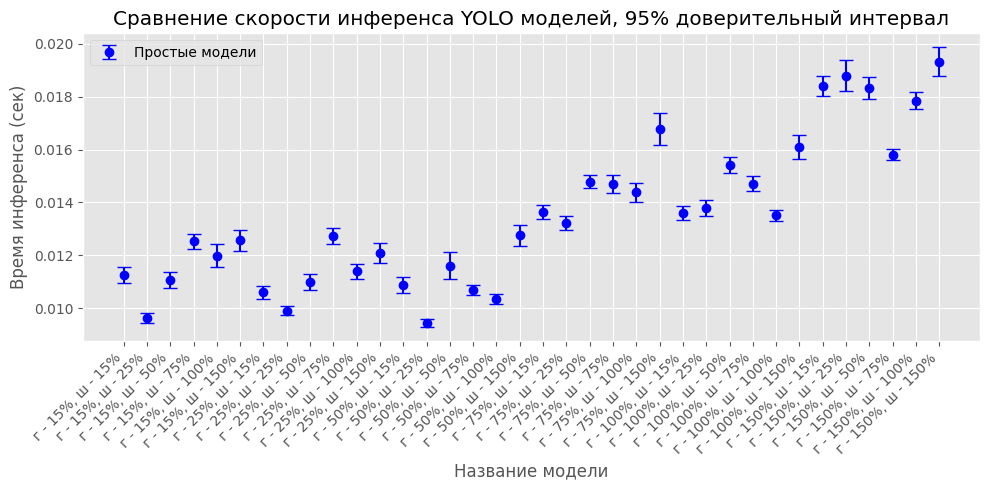

In [ ]:
evaluate_models(logs_dir, image_path, num_runs=250, extra_measure = False)

/home/user/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/user/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weig

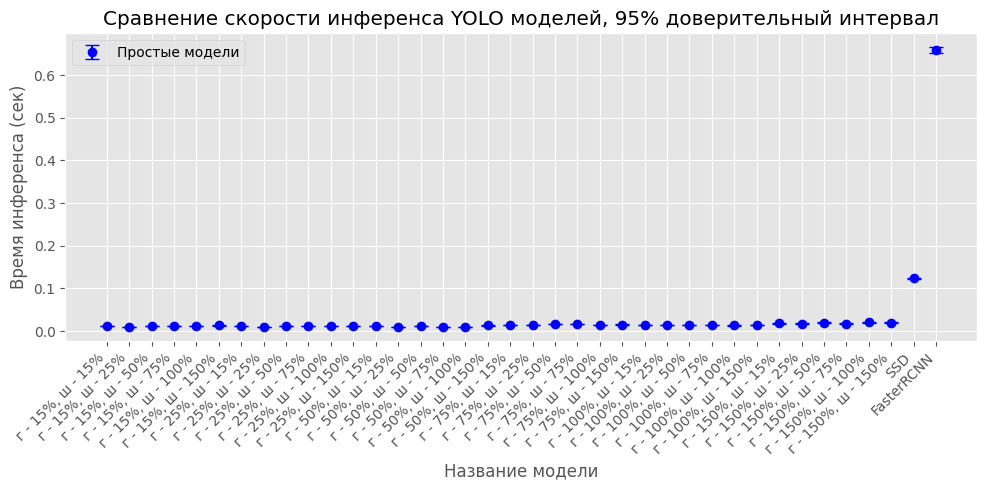

In [377]:
evaluate_models(logs_dir, image_path, num_runs=250, extra_measure = True)

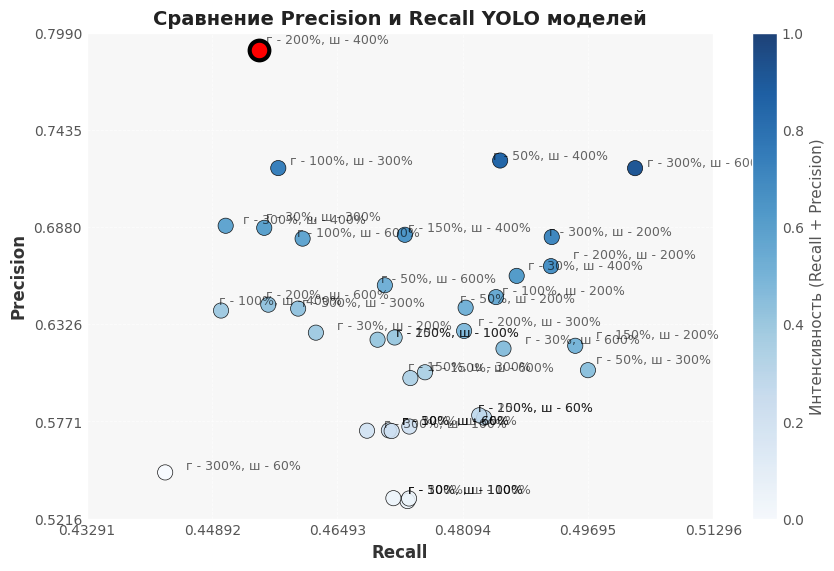

In [122]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Базовый размер модели YOLO
base_yolo_size = [0.50, 0.25]

def extract_model_size(folder_name):
    """Извлекает depth и width из названия папки в формате [depth_xx-width_xx] и переводит в формат 'г - n%, ш - k%'"""
    match = re.search(r"\[depth_(\d+\.\d+)-width_(\d+\.\d+)\]", folder_name)
    if match:
        depth = float(match.group(1)) * 100
        width = float(match.group(2)) * 100

        # Переводим в проценты относительно базового размера
        depth_percent = (float(match.group(1)) / base_yolo_size[0]) * 100
        width_percent = (float(match.group(2)) / base_yolo_size[1]) * 100

        return f"г - {int(depth_percent)}%, ш - {int(width_percent)}%"
    return None

def get_max_metrics(csv_path):
    """Извлекает максимальные Precision и Recall из results.csv"""
    try:
        df = pd.read_csv(csv_path)
        max_precision = df["metrics/precision(B)"].max()
        max_recall = df["metrics/recall(B)"].max()
        return max_precision, max_recall
    except Exception as e:
        print(f"Ошибка при обработке {csv_path}: {e}")
        return None, None

def evaluate_models(logs_dir):
    """Собирает Precision и Recall всех моделей и строит улучшенный график"""
    results = {}

    for folder in sorted(os.listdir(logs_dir)):
        folder_path = os.path.join(logs_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        model_name = extract_model_size(folder)
        if not model_name:
            continue

        csv_path = os.path.join(folder_path, "results.csv")
        if os.path.exists(csv_path):
            max_precision, max_recall = get_max_metrics(csv_path)
            if max_precision is not None and max_recall is not None:
                results[model_name] = (max_precision, max_recall)

    # Преобразуем данные для градиента цвета
    recalls = np.array([r[1] for r in results.values()])
    precisions = np.array([r[0] for r in results.values()])
    colors = recalls + precisions  # Чем выше recall + precision, тем ярче цвет
    norm_colors = (colors - colors.min()) / (colors.max() - colors.min())  # Нормализация

    # Добавляем jitter (разброс) для избежания наложения точек
    jitter_strength = 0.002
    recalls += np.random.uniform(-jitter_strength, jitter_strength, size=len(recalls))
    precisions += np.random.uniform(-jitter_strength, jitter_strength, size=len(precisions))

    # Стиль графика
    plt.style.use("ggplot")  # Применение стиля seaborn-muted

    fig, ax = plt.subplots(figsize=(9, 6))
    scatter = ax.scatter(recalls, precisions, c=norm_colors, cmap="Blues", s=120, edgecolors="black", alpha=0.9)

    # Найдем точку с максимальной суммой (precision + recall)
    max_sum_index = np.argmax(precisions + recalls)  # Индекс точки с максимальной суммой
    ax.scatter(recalls[max_sum_index], precisions[max_sum_index], c='red', s=200, edgecolors='black', linewidth=3, alpha=1)

    # Добавляем подписи с прозрачностью текста
    for model, (precision, recall) in results.items():
        ax.text(recall + 0.001, precision + 0.001, model, fontsize=9, color = 'black',
                ha="left", va="bottom", alpha=0.6)

    # Динамический масштаб осей
    ax.set_xlim(max(0, min(recalls) - 0.01), min(1.05, max(recalls) + 0.01))
    ax.set_ylim(max(0, min(precisions) - 0.01), min(1.05, max(precisions) + 0.01))

    # Улучшаем стиль осей
    ax.set_xlabel("Recall", fontsize=12, fontweight="bold", color="#333")
    ax.set_ylabel("Precision", fontsize=12, fontweight="bold", color="#333")
    ax.set_title("Сравнение Precision и Recall YOLO моделей", fontsize=14, fontweight="bold", color="#222")

    ax.set_xticks(np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 6))
    ax.set_yticks(np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 6))

    # Улучшенный фон и сетка
    ax.set_facecolor("#F7F7F7")
    ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.7)

    # Добавляем цветовую шкалу
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Интенсивность (Recall + Precision)", fontsize=11)

    plt.show()

# Пути
logs_dir = "../detection/logs/yolo11/"

# Запуск
evaluate_models(logs_dir)


In [406]:
import os
os.path.getsize('../detection/logs/yolo11/[depth_0.5-width_1.5]/weights/best.pt')/1024

159439.7685546875

In [269]:
import math

def euclidean_distance_2d(point1, point2):
    """Вычисляет евклидово расстояние между двумя точками в 2D пространстве"""
    return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)


In [279]:
euclidean_distance_2d([0.55, 0.6], [0.54, 0.6])

0.010000000000000009

1 base 0.6074664752701311 107085811
2 base 0.6032447003786671 20638291
3 base 0.6027185938219262 81419347
1 extra 0.6080691310984138 15743188
2 extra 0.5980919693186162 115424436
3 extra 0.5889677541120668 22495764


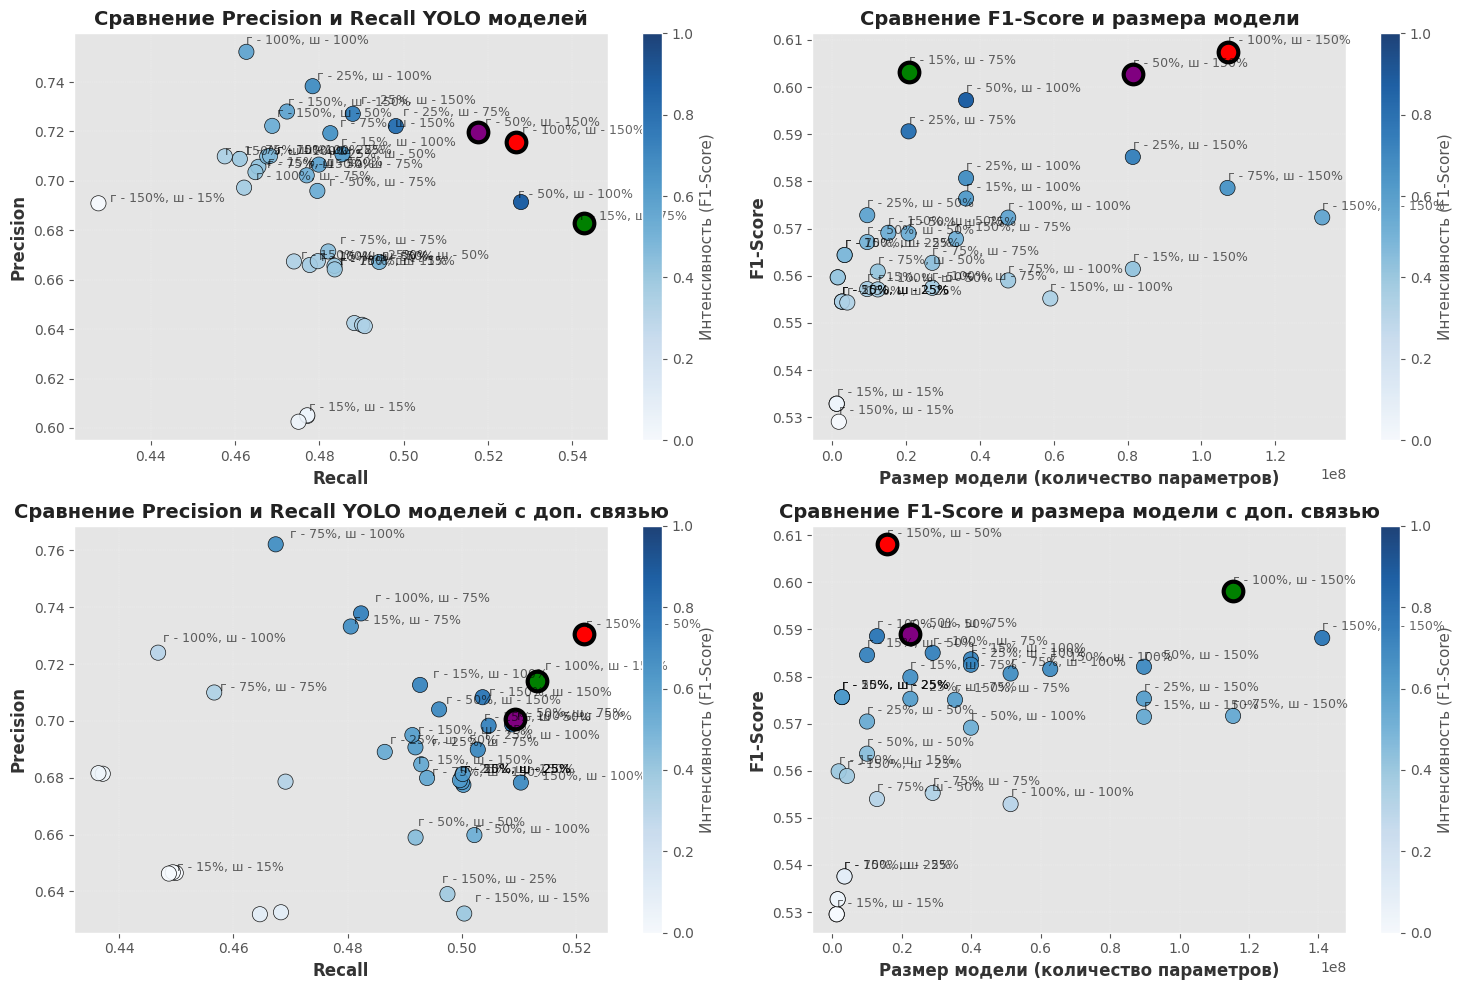

In [396]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from ultralytics import YOLO
import math

# Базовый размер модели YOLO
base_yolo_size = [0.50, 0.25]

def extract_model_size(folder_name):
    """Извлекает параметры depth и width из названия папки в формате [depth_xx-width_xx] и переводит в формат 'г - n%, ш - k%'"""
    match = re.search(r"\[depth_(\d+\.\d+)-width_(\d+\.\d+)\]", folder_name)
    if match:
        depth = float(match.group(1)) * 100
        width = float(match.group(2)) * 100

        # Переводим в проценты относительно базового размера
        depth_percent = (float(match.group(1))) * 100
        width_percent = (float(match.group(2))) * 100
        if folder_name.startswith('extra13'):
            return f"extra г - {int(depth_percent)}%, ш - {int(width_percent)}%" 
        elif folder_name.startswith('['):
            return f"г - {int(depth_percent)}%, ш - {int(width_percent)}%"
        #return f"г - {int(depth_percent)}%, ш - {int(width_percent)}%"
    return None

def get_max_metrics(csv_path):
    """Извлекает максимальные Precision и Recall из results.csv"""
    try:
        df = pd.read_csv(csv_path)
        max_precision = df["metrics/precision(B)"].max()
        max_recall = df["metrics/recall(B)"].max()
        return max_precision, max_recall
    except Exception as e:
        print(f"Ошибка при обработке {csv_path}: {e}")
        return None, None

def get_model_parameters(model_path):
    """Возвращает количество параметров модели YOLO"""
    model = YOLO(model_path)
    params = sum(p.numel() for p in model.parameters())  # Суммируем все параметры модели
    return params

def euclidean_distance_2d(point1, point2):
    """Вычисляет евклидово расстояние между двумя точками в 2D пространстве"""
    return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

def evaluate_models(logs_dir):
    """Собирает Precision, Recall и количество параметров всех моделей и строит два графика"""
    results = {'extra': {}, 'base': {}}
    # Стиль графика
    plt.style.use("ggplot")  # Применение стиля ggplot
    for folder in sorted(os.listdir(logs_dir)):
        folder_path = os.path.join(logs_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        model_name = extract_model_size(folder)
        if not model_name:
            continue

        csv_path = os.path.join(folder_path, "results.csv")
        if os.path.exists(csv_path):
            max_precision, max_recall = get_max_metrics(csv_path)
            if max_precision is not None and max_recall is not None:
                # Вычисление F1-скора
                f1_score = 2 * (max_precision * max_recall) / (max_precision + max_recall) if max_precision + max_recall != 0 else 0
                weights_path = os.path.join(folder_path, "weights", "best.pt")
                num_params = get_model_parameters(weights_path)  # Получаем количество параметров
                if 'extra' in folder_path:
                    results['extra'][model_name.replace('extra ', '')] = (max_precision, max_recall, num_params, f1_score)  # Добавляем F1-скор
                else:
                    results['base'][model_name] = (max_precision, max_recall, num_params, f1_score)  # Добавляем F1-скор
    
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    for i, mode in enumerate(['base', 'extra']):
        # Преобразуем данные для градиента цвета
        recalls = np.array([r[1] for r in results[mode].values()])
        precisions = np.array([r[0] for r in results[mode].values()])
        model_sizes = np.array([r[2] for r in results[mode].values()])
        f1_scores = np.array([r[3] for r in results[mode].values()])  # Массив для F1-скора

        # Нормализация цвета для F1-скора
        norm_colors = (f1_scores - f1_scores.min()) / (f1_scores.max() - f1_scores.min())  # Нормализация цвета 
        # Добавляем jitter (разброс) для избежания наложения точек
        jitter_strength = 0.002
        recalls += np.random.uniform(-jitter_strength, jitter_strength, size=len(recalls))
        precisions += np.random.uniform(-jitter_strength, jitter_strength, size=len(precisions))

        # Определяем индексы моделей с наибольшими значениями precision + recall
        sorted_indices = np.argsort(f1_scores)[::-1]  # Сортируем по убыванию
        max_sum_index = sorted_indices[0]  # 1-е место (красная точка)
        second_sum_index = sorted_indices[1] if len(sorted_indices) > 1 else None  # 2-е место (зеленая точка)
        third_sum_index = sorted_indices[2] if len(sorted_indices) > 2 else None  # 3-е место (фиолетовая точка)
 
        # График Precision vs Recall
        scatter1 = ax[i][0].scatter(recalls, precisions, c=norm_colors, cmap="Blues", s=120, edgecolors="black", alpha=0.9)

        # Выделяем топ-3 модели
        ax[i][0].scatter(recalls[max_sum_index], precisions[max_sum_index], c='red', s=200, edgecolors='black', linewidth=3, alpha=1)
        if second_sum_index is not None:
            ax[i][0].scatter(recalls[second_sum_index], precisions[second_sum_index], c='green', s=200, edgecolors='black', linewidth=3, alpha=1)
        if third_sum_index is not None:
            ax[i][0].scatter(recalls[third_sum_index], precisions[third_sum_index], c='purple', s=200, edgecolors='black', linewidth=3, alpha=1)

        ax[i][0].set_xlabel("Recall", fontsize=12, fontweight="bold", color="#333")
        ax[i][0].set_ylabel("Precision", fontsize=12, fontweight="bold", color="#333") 
        ax[i][0].grid(True, linestyle="--", linewidth=0.3, alpha=0.5)  # Легкая сетка
        cbar1 = plt.colorbar(scatter1, ax=ax[i, 0])
        cbar1.set_label("Интенсивность (F1-Score)", fontsize=11)

        # График Precision vs Model Size (Количество параметров) с F1-Score на оси Y
        scatter2 = ax[i][1].scatter(model_sizes, f1_scores, c=norm_colors, cmap="Blues", s=120, edgecolors="black", alpha=0.9)

        # Выделяем топ-3 модели на правом графике
        ax[i][1].scatter(model_sizes[max_sum_index], f1_scores[max_sum_index], c='red', s=200, edgecolors='black', linewidth=3, alpha=1)
        print(1, mode, f1_scores[max_sum_index], model_sizes[max_sum_index])
        if second_sum_index is not None:
            ax[i][1].scatter(model_sizes[second_sum_index], f1_scores[second_sum_index], c='green', s=200, edgecolors='black', linewidth=3, alpha=1)
            print(2, mode, f1_scores[second_sum_index], model_sizes[second_sum_index])
        if third_sum_index is not None:
            ax[i][1].scatter(model_sizes[third_sum_index], f1_scores[third_sum_index], c='purple', s=200, edgecolors='black', linewidth=3, alpha=1)
            print(3, mode, f1_scores[third_sum_index], model_sizes[third_sum_index])
    
        seen_coords_prec = []
        seen_coords_f1 = []
        # Добавляем подписи с прозрачностью текста
        for model, (precision, recall, size, f1_score) in results[mode].items():
            prec_flag, f1_flag = False, False
            if not seen_coords_prec:
                ax[i][0].text(recall + 0.001, precision + 0.001, model, fontsize=9, color='black', ha="left", va="bottom", alpha=0.6)
                ax[i][1].text(size + 0.001, f1_score + 0.001, model, fontsize=9, color='black', ha="left", va="bottom", alpha=0.6) 
                seen_coords_prec.append([precision, recall])
                seen_coords_f1.append([size, f1_score])
                continue
            
            for precision_new, recall_new in seen_coords_prec:
                if euclidean_distance_2d([precision_new, recall_new], [precision, recall]) < 0.04:
                    prec_flag = True
            if not prec_flag:
                ax[i][0].text(recall + 0.001, precision + 0.001, model, fontsize=9, color='black', ha="left", va="bottom", alpha=0.6)
                seen_coords_prec.append([precision_new, recall_new])
            for size_new, f1_score_new in seen_coords_f1:
                if euclidean_distance_2d([size_new/1e7, f1_score_new], [size/1e7, f1_score]) < 0.05: 
                    f1_flag = True
            if not f1_flag:
                ax[i][1].text(size + 0.001, f1_score + 0.001, model, fontsize=9, color='black', ha="left", va="bottom", alpha=0.6) 
                seen_coords_f1.append([size_new, f1_score_new])
                     
        ax[i][1].set_xlabel("Размер модели (количество параметров)", fontsize=12, fontweight="bold", color="#333")
        ax[i][1].set_ylabel("F1-Score", fontsize=12, fontweight="bold", color="#333") 
        ax[i][1].grid(True, linestyle="--", linewidth=0.3, alpha=0.5)  # Легкая сетка
        cbar2 = plt.colorbar(scatter2, ax=ax[i, 1])
        cbar2.set_label("Интенсивность (F1-Score)", fontsize=11)
    
    ax[0][1].set_title("Сравнение F1-Score и размера модели", fontsize=14, fontweight="bold", color="#222")
    ax[0][0].set_title("Сравнение Precision и Recall YOLO моделей", fontsize=14, fontweight="bold", color="#222")
    ax[1][1].set_title("Сравнение F1-Score и размера модели с доп. связью", fontsize=14, fontweight="bold", color="#222")
    ax[1][0].set_title("Сравнение Precision и Recall YOLO моделей с доп. связью", fontsize=14, fontweight="bold", color="#222")
    
    


    plt.tight_layout() 
    plt.show()

# Пути
logs_dir = "../detection/logs/yolo11/"

# Запуск
evaluate_models(logs_dir)


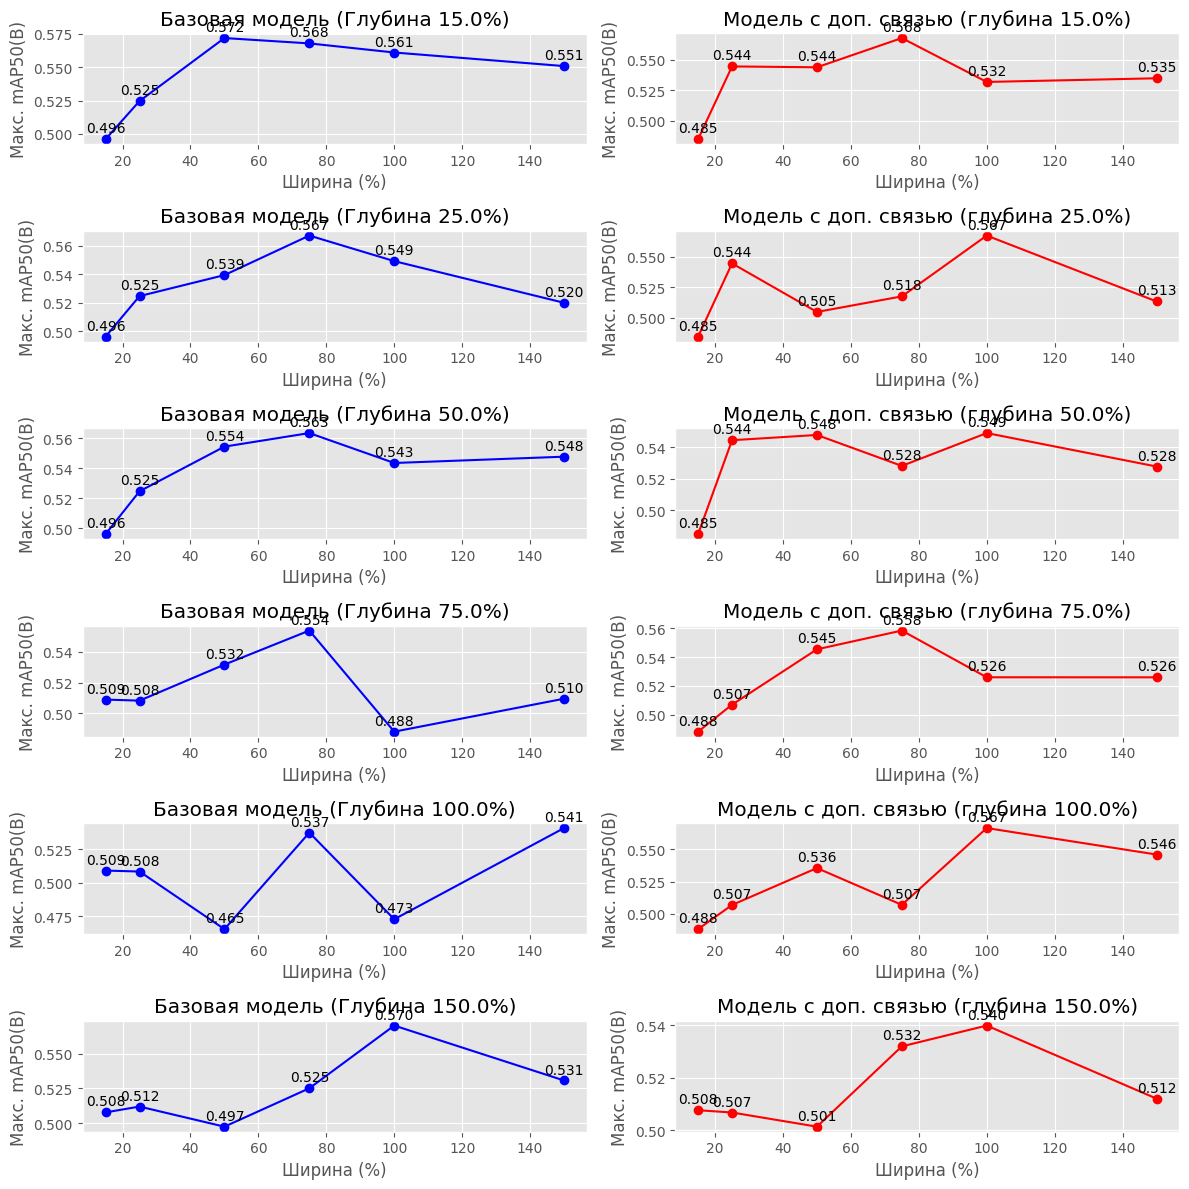

In [412]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def extract_model_size(folder_name):
    """Извлекает параметры depth и width из названия папки в формате [depth_xx-width_xx] и переводит в проценты относительно базового размера"""
    match = re.search(r"\[depth_(\d+\.\d+)-width_(\d+\.\d+)\]", folder_name)
    if match:
        depth = float(match.group(1)) * 100
        width = float(match.group(2)) * 100
        return depth, width
    return None, None

def get_max_mAP(csv_path):
    """Извлекает максимальное значение metrics/mAP50(B) из results.csv"""
    try:
        df = pd.read_csv(csv_path)
        max_map = df["metrics/mAP50(B)"].max()
        return max_map
    except Exception as e:
        print(f"Ошибка при обработке {csv_path}: {e}")
        return None

def gather_data(logs_dir, extra=False):
    """Собирает данные для построения графика для моделей (с/без 'extra')"""
    model_data = defaultdict(list)
    # Стиль графика
    plt.style.use("ggplot")
    for folder in sorted(os.listdir(logs_dir)):
        if folder.startswith("extra_"):
            continue
        folder_path = os.path.join(logs_dir, folder)
        if not os.path.isdir(folder_path):
            continue
        
        if extra and not folder.startswith("extra13"):
            continue
        if not extra and folder.startswith("extra13"):
            continue

        # Извлекаем параметры модели
        depth, width = extract_model_size(folder)
        if depth is None or width is None:
            continue

        # Путь до файла results.csv
        csv_path = os.path.join(folder_path, "results.csv")
        max_map = get_max_mAP(csv_path)
        if max_map is not None:
            model_data[depth].append((width, max_map))

    return model_data

# Получаем данные для всех моделей и для моделей с 'extra_'
logs_dir = "/home/user/master_degree/pits_detection/detection/logs/yolo11"
base_data = gather_data(logs_dir, extra=False)
extra_data = gather_data(logs_dir, extra=True)

# Определяем количество уникальных значений глубины (depth) для построения графиков
num_depths = len(base_data)

# Построение графиков
fig, ax = plt.subplots(num_depths, 2, figsize=(12, 12))

# Графики для базовых моделей
for i, (depth, data) in enumerate(base_data.items()):
    widths = [d[0] for d in data]
    maps = [d[1] for d in data]

    ax[i, 0].plot(widths, maps, 'bo-', label=f'Глубина {depth}%') 
    for x, y in zip(widths, maps):
        ax[i, 0].annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,5), ha='center') 
    ax[i, 0].set_title(f'Базовая модель (Глубина {depth}%)')
    ax[i, 0].set_xlabel('Ширина (%)')
    ax[i, 0].set_ylabel('Макс. mAP50(B)')
    ax[i, 0].grid(True)

# Графики для моделей с "extra_"
for i, (depth, data) in enumerate(extra_data.items()):
    widths = [d[0] for d in data]
    maps = [d[1] for d in data]

    ax[i, 1].plot(widths, maps, 'ro-', label=f'Depth {depth}%')
    for x, y in zip(widths, maps):
        ax[i, 1].annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,5), ha='center') 
    ax[i, 1].set_title(f'Модель с доп. связью (глубина {depth}%)')
    ax[i, 1].set_xlabel('Ширина (%)')
    ax[i, 1].set_ylabel('Макс. mAP50(B)')
    ax[i, 1].grid(True)

# Отображаем график

plt.tight_layout()
plt.show()




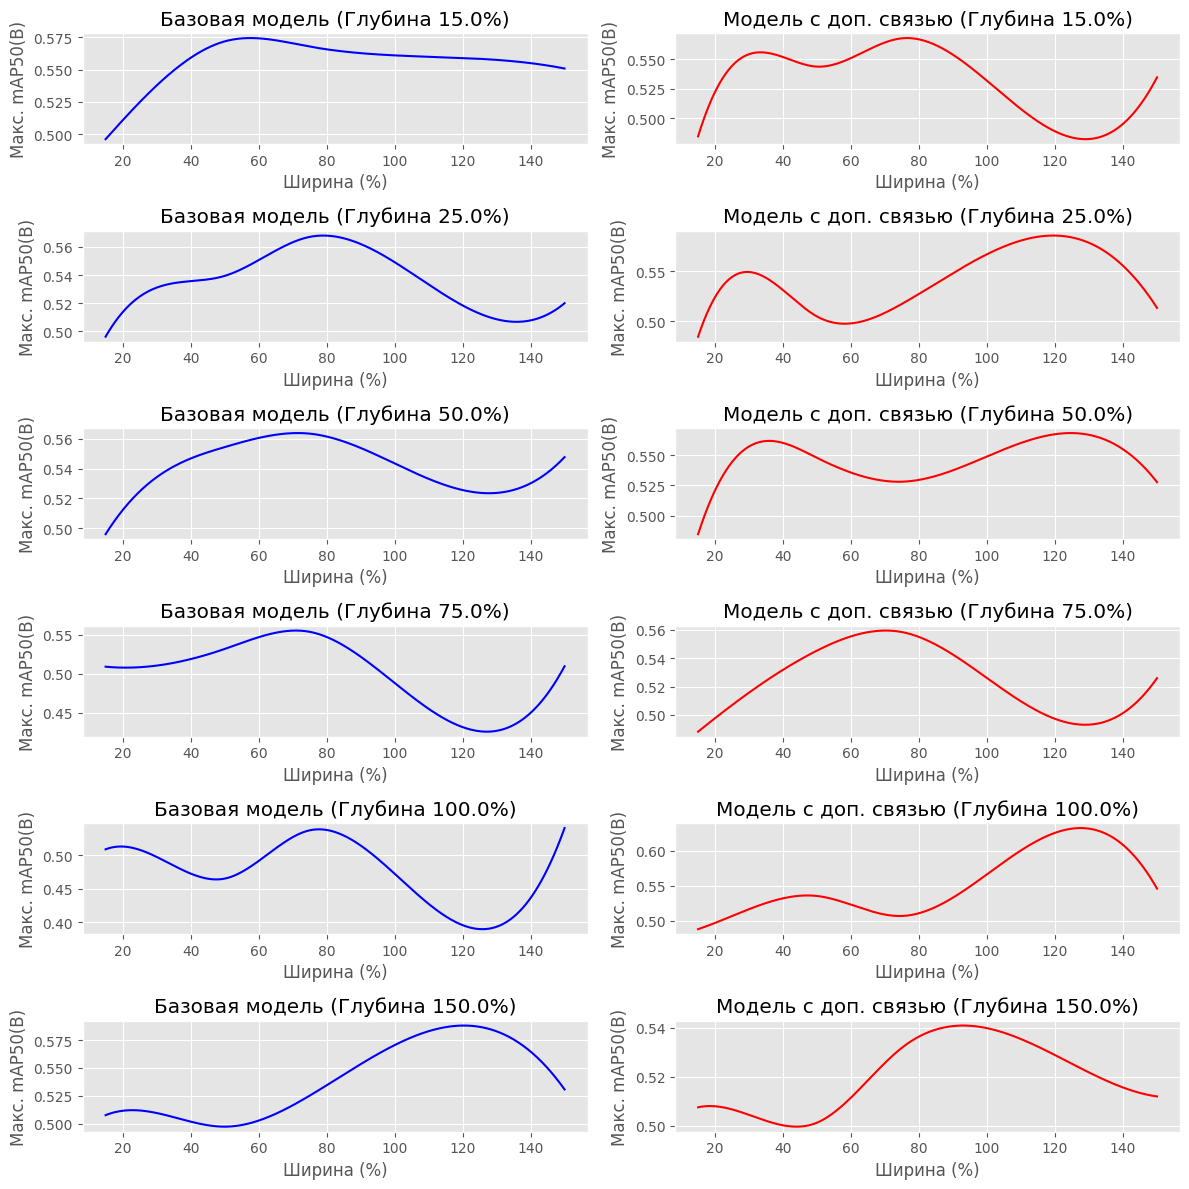

In [413]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.interpolate import make_interp_spline

def extract_model_size(folder_name):
    """Извлекает параметры depth и width из названия папки в формате [depth_xx-width_xx] и переводит в проценты относительно базового размера"""
    match = re.search(r"\[depth_(\d+\.\d+)-width_(\d+\.\d+)\]", folder_name)
    if match:
        depth = float(match.group(1)) * 100
        width = float(match.group(2)) * 100
        return depth, width
    return None, None

def get_max_mAP(csv_path):
    """Извлекает максимальное значение metrics/mAP50(B) из results.csv"""
    try:
        df = pd.read_csv(csv_path)
        max_map = df["metrics/mAP50(B)"].max()
        return max_map
    except Exception as e:
        print(f"Ошибка при обработке {csv_path}: {e}")
        return None

def gather_data(logs_dir, extra=False):
    """Собирает данные для построения графика для моделей (с/без 'extra')"""
    model_data = defaultdict(list)
    # Стиль графика
    plt.style.use("ggplot")
    for folder in sorted(os.listdir(logs_dir)):
        if folder.startswith("extra_"):
            continue
        folder_path = os.path.join(logs_dir, folder)
        if not os.path.isdir(folder_path):
            continue
        
        if extra and not folder.startswith("extra13"):
            continue
        if not extra and folder.startswith("extra13"):
            continue

        # Извлекаем параметры модели
        depth, width = extract_model_size(folder)
        if depth is None or width is None:
            continue

        # Путь до файла results.csv
        csv_path = os.path.join(folder_path, "results.csv")
        max_map = get_max_mAP(csv_path)
        if max_map is not None:
            model_data[depth].append((width, max_map))

    return model_data

# Получаем данные для всех моделей и для моделей с 'extra_'
logs_dir = "/home/user/master_degree/pits_detection/detection/logs/yolo11"
base_data = gather_data(logs_dir, extra=False)
extra_data = gather_data(logs_dir, extra=True)

# Определяем количество уникальных значений глубины (depth) для построения графиков
num_depths = len(base_data)

# Построение графиков
fig, ax = plt.subplots(num_depths, 2, figsize=(12, 12))

# Графики для базовых моделей
for i, (depth, data) in enumerate(base_data.items()):
    widths = [d[0] for d in data]
    maps = [d[1] for d in data]

    # Интерполяция для создания гладкой линии
    xnew = np.linspace(min(widths), max(widths), 300)  # 300 точек для плавности
    spl = make_interp_spline(widths, maps, k=3)  # Кубическая интерполяция
    ynew = spl(xnew)

    ax[i, 0].plot(xnew, ynew, 'b-', label=f'Глубина {depth}%')  # Без маркеров, только линия
    ax[i, 0].set_title(f'Базовая модель (Глубина {depth}%)')
    ax[i, 0].set_xlabel('Ширина (%)')
    ax[i, 0].set_ylabel('Макс. mAP50(B)')
    ax[i, 0].grid(True)

# Графики для моделей с "extra_"
for i, (depth, data) in enumerate(extra_data.items()):
    widths = [d[0] for d in data]
    maps = [d[1] for d in data]

    # Интерполяция для создания гладкой линии
    xnew = np.linspace(min(widths), max(widths), 300)  # 300 точек для плавности
    spl = make_interp_spline(widths, maps, k=3)  # Кубическая интерполяция
    ynew = spl(xnew)

    ax[i, 1].plot(xnew, ynew, 'r-', label=f'Глубина {depth}%')  # Без маркеров, только линия
    ax[i, 1].set_title(f'Модель с доп. связью (Глубина {depth}%)')
    ax[i, 1].set_xlabel('Ширина (%)')
    ax[i, 1].set_ylabel('Макс. mAP50(B)')
    ax[i, 1].grid(True)

# Отображаем график
plt.tight_layout()
plt.show()


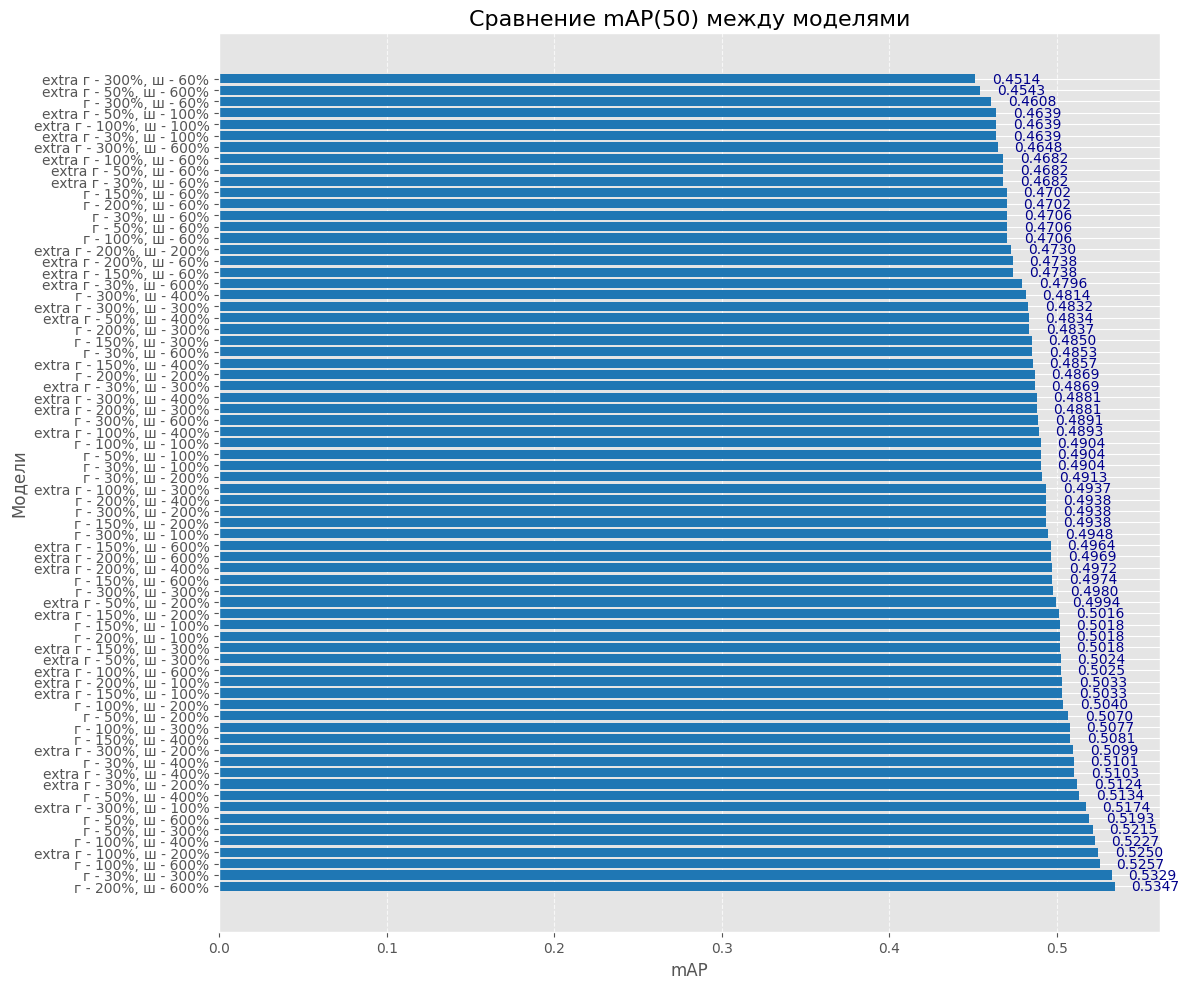

In [293]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import re  # Для работы с регулярными выражениями

# Путь к папке с логами
logs_path = '/home/user/master_degree/pits_detection/detection/logs/yolo11'
# Базовый размер модели YOLO
base_yolo_size = [0.50, 0.25]
# Список моделей
model_folders = [f for f in os.listdir(logs_path) if os.path.isdir(os.path.join(logs_path, f))]

# Список mAP для каждой модели
model_names = []
map_values = []

# Функция для преобразования названий папок
def format_folder_name(folder_name):
    match = re.search(r'depth_(\d+\.\d+)-width_(\d+\.\d+)', folder_name)
    if match: 
        # Переводим в проценты относительно базового размера
        depth_percent = (float(match.group(1)) / base_yolo_size[0]) * 100
        width_percent = (float(match.group(2)) / base_yolo_size[1]) * 100
        if folder_name.startswith('extra'):
            return f"extra г - {int(depth_percent)}%, ш - {int(width_percent)}%" 
        return f"г - {int(depth_percent)}%, ш - {int(width_percent)}%"
    return folder_name

for folder in model_folders:
    result_csv = os.path.join(logs_path, folder, 'results.csv')
    if os.path.exists(result_csv):
        df = pd.read_csv(result_csv)
        # Предполагаем, что столбец 'mAP' в результатах csv
        mAP = df['metrics/mAP50(B)'].max()  # Берем максимальный mAP
        model_names.append(folder)
        map_values.append(mAP)

 
# Преобразуем все названия папок на оси Y
formatted_model_names = [format_folder_name(name) for name in model_names]

# Сортируем данные по значениям mAP (по убыванию)
sorted_data = sorted(zip(formatted_model_names, map_values), key=lambda x: x[1], reverse=True)

# Разделяем отсортированные данные обратно на отдельные списки
sorted_model_names, sorted_map_values = zip(*sorted_data)

# Построение графика
plt.figure(figsize=(12, 10))
plt.barh(sorted_model_names, sorted_map_values, color='#1f77b4')  # Используем синий оттенок

# Настройка графика
plt.xlabel('mAP', fontsize=12)
plt.ylabel('Модели', fontsize=12)
plt.title('Сравнение mAP(50) между моделями', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Добавляем значения mAP на график
for i, (value, name) in enumerate(zip(sorted_map_values, sorted_model_names)):
    plt.text(value + 0.01, i, f'{value:.4f}', va='center', fontsize=10, color='darkblue')

# Показать график
plt.tight_layout()
plt.show()


In [370]:
import cv2
import segmentation_models_pytorch as smp
import torch
import numpy as np
import os
from pathlib import Path
from sklearn.metrics import precision_score, recall_score

# Параметр порога пересечения
iou_threshold = 0.5  
precision_before_all, recall_before_all = [], []
precision_after_all, recall_after_all = [], []
# Функция для вычисления IoU между маской дороги и детекцией
def compute_iou_segment(mask, box):
    x1, y1, x2, y2 = map(int, box) 
    roi = mask[y1:y2, x1:x2]
    intersection = np.sum(roi)  # Количество пикселей, попавших в сегментированную дорогу
    box_area = (x2 - x1) * (y2 - y1)
    iou = intersection / box_area if box_area > 0 else 0
    return iou

def clean_segmentation_mask(pred_mask, min_region_size=250):
    """
    Очищает сегментационную маску от случайных пикселей, оставляя только главный регион.
    
    :param pred_mask: Входная бинарная маска (numpy array, 0 и 1).
    :param min_region_size: Минимальный размер области, которую считаем значимой.
    :return: Очищенная бинарная маска (0 и 1).
    """
    # Убедимся, что тип данных uint8 (требуется для OpenCV)
    pred_mask = (pred_mask * 255).astype(np.uint8)

    # Морфологическое закрытие (убираем разрывы и одиночные пиксели)
    kernel = np.ones((2, 2), np.uint8)
    pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Убираем мелкие шумные компоненты (поиск связных областей)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(pred_mask, connectivity=8)

    # Если найдено несколько областей, оставляем только самую большую
    new_mask = np.zeros_like(pred_mask)
    
    # Перебираем все найденные компоненты
    for i in range(1, num_labels):  # Первый индекс (0) — фон
        area = stats[i, cv2.CC_STAT_AREA]
        if area > min_region_size:  # Условие: оставить только большие регионы
            new_mask[labels == i] = 255  # Заполняем найденную область белым

    return (new_mask > 0).astype(np.uint8)  # Преобразуем обратно в 0 и 1

def compute_iou(box1, box2):
    """ Функция вычисления IoU (Intersection over Union) между двумя боксами """
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    # Определяем координаты пересечения
    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)

    # Вычисляем площадь пересечения
    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    intersection = inter_width * inter_height

    # Площади боксов
    area1 = (x2 - x1) * (y2 - y1)
    area2 = (x2g - x1g) * (y2g - y1g)

    # Вычисляем IoU
    iou = intersection / float(area1 + area2 - intersection)
    return iou


def get_seg_model(encoder_name, checkpoint_path = f'../segmantation/logs/Linknet/resnet101/version_4/checkpoints/epoch=79-step=1360.ckpt'): 
    seg_model = smp.create_model(
                'Linknet',
                encoder_name=encoder_name,
                in_channels=3,
                classes=1 )  
    new_weights = rename_state_dict(checkpoint_path, seg_model)
    seg_model.load_state_dict(new_weights) 
    seg_model.eval()
    return seg_model

def get_det_model(checkpoint_path = f'detection/logs/yolo11/[depth_1.0-width_1.5]/weights/best.pt'):
    return YOLO(checkpoint_path) 

def get_mask(image_numpy, seg_model):
    #checkpoint_path = f'logs/{model_name}/resnet34/version_0/checkpoints/epoch=199-step=9200.ckpt' 
    tensor_img = torch.tensor(image_numpy / 255, dtype=torch.float32)
    mean = torch.tensor([[[[0.4850]], [[0.4560]], [[0.4060]]]])
    std = torch.tensor([[[[0.2290]], [[0.2240]], [[0.2250]]]])
    with torch.no_grad():
        tensor_img = (tensor_img - mean) / std
        logits_mask = seg_model(tensor_img)
    prob_mask = logits_mask.sigmoid()
    pred_mask = (prob_mask > 0.1).float()
    
    return clean_segmentation_mask(pred_mask.squeeze().detach().numpy())

# Фильтрация боксов, которые пересекаются с дорогой
def filter_boxes(yolo_boxes, yolo_confs, mask, threshold=0.3):
    filtered_boxes = []
    filtered_confs = []
    for box, conf in zip(yolo_boxes, yolo_confs):
        iou = compute_iou_segment(mask, box)
        if iou >= threshold:
            filtered_boxes.append(box)
            filtered_confs.append(conf)
    return np.array(filtered_boxes), np.array(filtered_confs)

# Функция для загрузки истинных боксов из YOLO-формата
def load_true_boxes(label_path, img_width, img_height):
    true_boxes = []
    with open(label_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            _, x, y, w, h = map(float, line.strip().split())
            x1 = int((x - w / 2) * img_width)
            y1 = int((y - h / 2) * img_height)
            x2 = int((x + w / 2) * img_width)
            y2 = int((y + h / 2) * img_height)
            true_boxes.append([x1, y1, x2, y2])
    return np.array(true_boxes)

# Функция для вычисления Precision и Recall
def calculate_metrics(pred_boxes, true_boxes, iou_threshold=0.5):
    true_labels = np.ones(max(len(true_boxes), len(pred_boxes)), dtype=int)
    pred_labels = np.zeros(max(len(true_boxes), len(pred_boxes)), dtype=int)
    for i, true_box in enumerate(true_boxes):
        for j, pred_box in enumerate(pred_boxes): 
            if compute_iou(true_box, pred_box) >= iou_threshold: 
                pred_labels[i] = 1 

    precision = precision_score(true_labels, pred_labels, zero_division=1)
    recall = recall_score(true_labels, pred_labels, zero_division=1)
    return precision, recall


def save_image_with_boxes(image, mask, yolo_boxes_before, yolo_boxes_after, output_path, img_w, img_h):
    """
    Сохраняет изображение, состоящее из 3 частей: маска, детекция до фильтрации, детекция после фильтрации.
    
    :param image: Оригинальное изображение
    :param mask: Маска сегментации
    :param yolo_boxes_before: Детекции до фильтрации
    :param yolo_boxes_after: Детекции после фильтрации
    :param output_path: Путь для сохранения результата
    """
     
    # Рисуем боксы на изображении до фильтрации
    image_before = image.copy()
    image_before = cv2.resize(image_before, (img_w, img_h))
    for box in yolo_boxes_before:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image_before, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Рисуем боксы на изображении после фильтрации
    image_after = image.copy()
    image_after = cv2.resize(image_after, (img_w, img_h))
    for box in yolo_boxes_after:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image_after, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Рисуем маску  
    mask_resized = cv2.resize(mask, (img_w, img_h))
    mask_colored_resized = np.stack([mask_resized*255] * 3, axis=-1)  # Маска как цветная картинка 
    # Объединяем все изображения
    combined_image = np.concatenate([mask_colored_resized, image_before, image_after], axis=1)

    # Сохраняем изображение
    cv2.imwrite(output_path, combined_image)


# Основной процесс
def process_images_and_save_results(images_path, labels_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for image_name in os.listdir(images_path):
        if not image_name.endswith(".jpg"):
            continue
        img_h = 512
        img_w = 512 
        image_path = os.path.join(images_path, image_name)
        label_path = os.path.join(labels_path, Path(image_name).stem + ".txt")

       # Читаем изображение
        frame = cv2.imread(image_path, 1)
        img_original = frame# cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img_original_resized = cv2.resize(img_original, (img_w,img_h))  
        img_original_transp = np.transpose(img_original_resized, (2, 0, 1)) 

        # Получаем маску сегментации
        mask = get_mask(image_numpy=img_original_transp, seg_model=seg_model) 

        # YOLO детекция
        detect_result = det_model(frame, conf=0.3, iou=0.3, verbose = False)
        yolo_boxes = detect_result[0].boxes.xyxy.cpu().numpy()
        yolo_confs = detect_result[0].boxes.conf.cpu().numpy()
        orig_h, orig_w, _ = frame.shape
        
        # Масштабируем YOLO боксы в размер mask (512x512)
        scale_x = img_w / orig_w
        scale_y = img_h / orig_h
        scaled_boxes = yolo_boxes.copy() 
        scaled_boxes[:, [0, 2]] *= scale_x  # x1, x2
        scaled_boxes[:, [1, 3]] *= scale_y  # y1, y2
        scaled_boxes = scaled_boxes.astype(int)  # Округляем до целых пикселей
        
        # Фильтрация боксов по пересечению с дорогой
        filtered_boxes, filtered_confs = filter_boxes(scaled_boxes, yolo_confs, mask, iou_threshold)
        
        # Загружаем истинные боксы
        if not os.path.exists(label_path):
            continue  # Пропускаем, если нет разметки
        true_boxes = load_true_boxes(label_path, img_w, img_h) 
        # Вычисление метрик до фильтрации
        precision_before, recall_before = calculate_metrics(scaled_boxes, true_boxes)
        if len(mask.shape) > 1:
            precision_after, recall_after = calculate_metrics(filtered_boxes, true_boxes) 
        else:
            precision_after, recall_after = precision_before, recall_before
        precision_before_all.append(precision_before)
        recall_before_all.append(recall_before)
        precision_after_all.append(precision_after)
        recall_after_all.append(recall_after)
        # Сохраняем результаты на изображении
        output_image_path = os.path.join(output_folder, f"{Path(image_name).stem}_result.jpg")
        save_image_with_boxes(img_original, mask, scaled_boxes, filtered_boxes, output_image_path, img_w, img_h)

        #print(f"Results saved for {image_name}. Precision before: {precision_before:.3f}, Recall before: {recall_before:.3f}")
       # print(f"Precision after: {precision_after:.3f}, Recall after: {recall_after:.3f}")
    print(f'Average precision before: {np.mean(precision_before_all)}, Average recall before: {np.mean(recall_before_all)}  \
          Average precision after: {np.mean(precision_after_all)}, Average recall after: {np.mean(recall_after_all)}')
# Запуск
images_path = "/home/user/master_degree/pits_detection/detection/data/yolo_format/images/train"
labels_path = "/home/user/master_degree/pits_detection/detection/data/yolo_format/labels/train"
output_folder = "train_pipeline_result"
 


In [371]:
process_images_and_save_results(images_path, labels_path, output_folder)

KeyboardInterrupt: 

[0.49613, 0.52463, 0.57172, 0.56773, 0.56092, 0.55077, 0.49613, 0.52463, 0.53938, 0.56716, 0.5492, 0.51994, 0.49613, 0.52463, 0.55429, 0.56331, 0.54342, 0.54761, 0.50895, 0.50826, 0.5316, 0.55363, 0.48818, 0.50952, 0.50895, 0.50826, 0.46525, 0.53728, 0.47264, 0.54068, 0.50776, 0.51196, 0.49746, 0.52516, 0.57041, 0.53078]
[0.48466, 0.54447, 0.54376, 0.56779, 0.53171, 0.53472, 0.48466, 0.54447, 0.50483, 0.51756, 0.5672, 0.51342, 0.48466, 0.54447, 0.54782, 0.52812, 0.54903, 0.52773, 0.48814, 0.50691, 0.54537, 0.5584, 0.52594, 0.5259, 0.48814, 0.50691, 0.53551, 0.50699, 0.56652, 0.546, 0.5076, 0.50673, 0.50133, 0.53196, 0.5399, 0.51203]


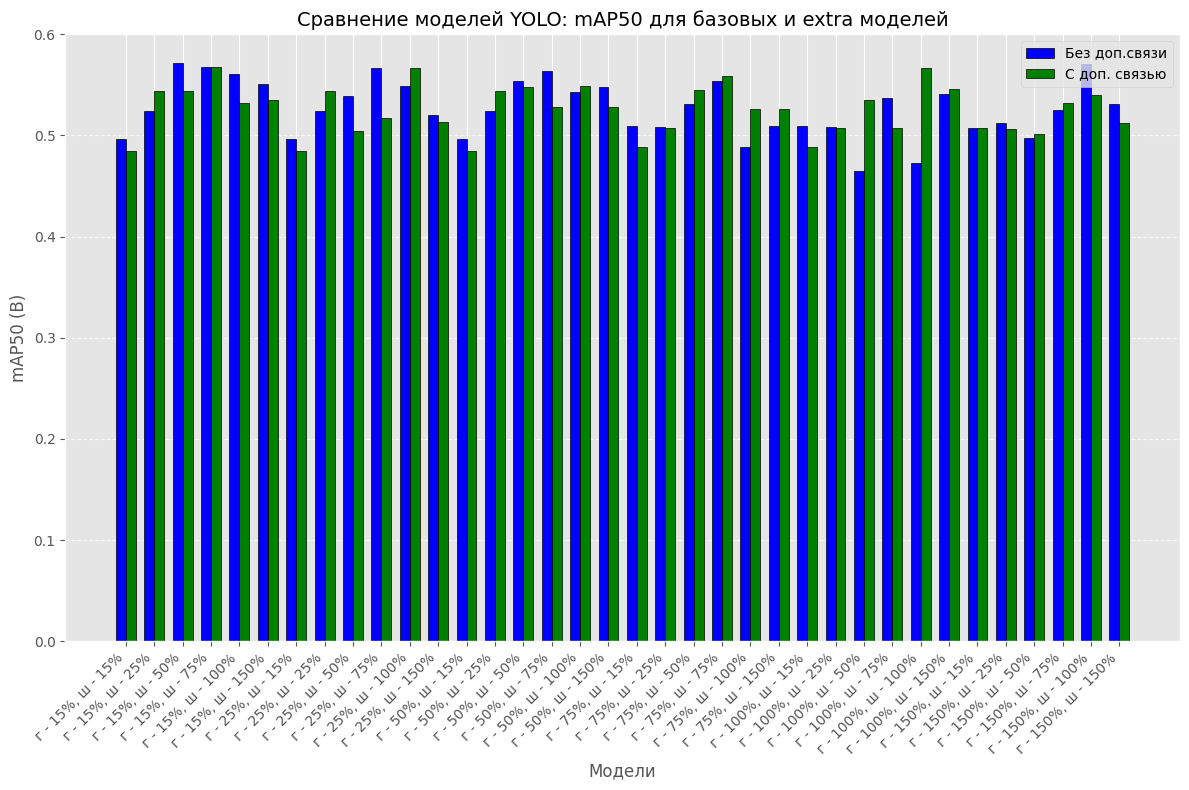

In [411]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Функция для извлечения глубины и ширины из названия папки
def extract_model_size(folder_name):
    """Извлекает параметры depth и width из названия папки в формате [depth_xx-width_xx]"""
    match = re.search(r"\[depth_(\d+\.\d+)-width_(\d+\.\d+)\]", folder_name)
    if match:
        depth = (float(match.group(1))) * 100
        width = (float(match.group(2))) * 100
        return depth, width
    return None, None

# Функция для получения максимального значения mAP50 из results.csv
def get_max_map(csv_path):
    """Извлекает максимальное значение mAP50 из results.csv"""
    try:
        df = pd.read_csv(csv_path)
        max_map = df["metrics/mAP50(B)"].max()
        return max_map
    except Exception as e:
        print(f"Ошибка при обработке {csv_path}: {e}")
        return None

# Функция для построения парных столбцов
def plot_comparison_bar_chart(logs_dir):
    """Строит график с парными столбцами для моделей YOLO"""
    model_names = []  # Список для хранения названий моделей
    mAP_values_base = []  # Список для значений mAP50 для базовых моделей
    mAP_values_extra = []  # Список для значений mAP50 для моделей с 'extra_'

    # Проходим по всем папкам с логами
    for folder in sorted(os.listdir(logs_dir)):
        if 'extra' in folder:
            continue
        folder_path = os.path.join(logs_dir, folder)
        if not os.path.isdir(folder_path):
            continue 
        # Извлекаем параметры модели из названия папки
        depth, width = extract_model_size(folder)
        if depth is None or width is None:
            continue
        
        # Получаем максимальное значение mAP50 из файла results.csv для базовой модели
        csv_path_base = os.path.join(folder_path, "results.csv")
        max_map_base = get_max_map(csv_path_base)

        if max_map_base is not None:
            model_name = f"г - {int(depth)}%, ш - {int(width)}%"
            model_names.append(model_name)
            mAP_values_base.append(max_map_base)

            # Для модели с префиксом "extra_" ищем результаты
            extra_folder = f"extra13_{folder}"
            extra_folder_path = os.path.join(logs_dir, extra_folder)

            if os.path.isdir(extra_folder_path):
                csv_path_extra = os.path.join(extra_folder_path, "results.csv")
                max_map_extra = get_max_map(csv_path_extra)
                mAP_values_extra.append(max_map_extra)
    # Стиль графика
    plt.style.use("ggplot")
    # Построение графика
    fig, ax = plt.subplots(figsize=(12, 8))

    # Индексы для парных столбцов
    x = np.arange(len(model_names))  # Позиции моделей по оси X
    width = 0.35  # Ширина столбца

    # Сортируем данные по значениям mAP (по убыванию)
    #sorted_data = sorted(zip(model_names, mAP_values_base), key=lambda x: x[1], reverse=True)
    #sorted_data_extra = sorted(zip(model_names, mAP_values_extra), key=lambda x: x[1], reverse=True)

    # Разделяем отсортированные данные обратно на отдельные списки
    #sorted_model_names_extra, sorted_map_values = zip(*sorted_data)
    #sorted_model_names_extra, sorted_map_values_extra = zip(*sorted_data_extra)
    
    print(mAP_values_base)
    print(mAP_values_extra)
    # Построение парных столбцов
    ax.bar(x - width/2, mAP_values_base, width, label='Без доп.связи', color='b', edgecolor='black')
    ax.bar(x + width/2, mAP_values_extra, width, label='С доп. связью', color='green', edgecolor='black')

    # Настроим подписи и титул
    ax.set_xlabel('Модели', fontsize=12)
    ax.set_ylabel('mAP50 (B)', fontsize=12)
    ax.set_title('Сравнение моделей YOLO: mAP50 для базовых и extra моделей', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)

    # Добавляем легенду
    ax.legend()

    # Улучшение вида графика
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Показываем график
    plt.show()

# Пример использования функции
logs_dir = "/home/user/master_degree/pits_detection/detection/logs/yolo11"
plot_comparison_bar_chart(logs_dir)


In [32]:
import torch 
import pytorch_lightning as pl
from torch import nn
from torchvision.models.detection import fasterrcnn_resnet50_fpn, ssd300_vgg16
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor 
from torchmetrics.detection.mean_ap import MeanAveragePrecision 


class ObjectDetectionModel(pl.LightningModule):
    def __init__(self, model_type: str, num_classes: int, lr: float):
        super().__init__()
        self.save_hyperparameters()
        self.model_type = model_type
        self.num_classes = num_classes
        self.lr = lr
        #self.train_loss = MeanMetric() 
        self.model_type = model_type

        if model_type == "mask_rcnn":
            self.model = fasterrcnn_resnet50_fpn(pretrained=True)#.to('cpu')
            in_features = self.model.roi_heads.box_predictor.cls_score.in_features
            self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        elif model_type == "ssd300":
            #self.model = ssd300_vgg16(pretrained=True)
            self.model = ssd300_vgg16(weights=True)
            #in_features = self.model.head.classification_head.num_classes
            #self.model.head.classification_head = SSDClassificationHead(in_features, num_classes)  
            
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        self.metric_train = MeanAveragePrecision()
        self.metric_val = MeanAveragePrecision()
        #self.training_step_losses = []
        #self.validation_step_losses = []
 

    def forward(self, images, targets=None):
        if targets:
            return self.model(images, targets)
        return self.model(images)

    def training_step(self, batch):
        images, targets = batch  
        # Прямой проход
        loss_dict = self.model(images, targets)  # Получаем потери 
        total_loss = sum(loss for loss in loss_dict.values())  # Суммируем все потери
        #self.training_step_losses.append(total_loss)

        # 🔄 Обновляем метрику
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(images)  # Предсказания для метрики 
        self.metric_train.update(outputs, targets) 

        # 🔄 Обновляем средний лосс
        #self.train_loss.update(total_loss)

        self.model.train()
        # 📝 Логируем лосс и метрики
        self.log("train_loss", total_loss, prog_bar=True, on_step=False, on_epoch=True, logger=True) 

        return total_loss

    def validation_step(self, batch):
        images, targets = batch 
        # Прямой проход (без градиентов)
        with torch.no_grad():
            # Получаем предсказания
            outputs = self.model(images)
        self.model.train()
        loss_dict = self.model(images, targets)  # Получаем потери 
         
        #print("AFTWR")
        #print(loss_dict)  
        total_loss = sum(loss for loss in loss_dict.values())  # Суммируем все потери в валидации
        self.model.eval()
        self.log("val_loss", total_loss, prog_bar=True, on_step=False, on_epoch=True, logger=True) 
        # 🔄 Обновляем метрику (используем предсказания `outputs` и реальные метки `targets`)
        self.metric_val.update(outputs, targets)  
        
        return total_loss

    def on_train_epoch_end(self):
        mAP = self.metric_train.compute()
        #epoch_loss = self.train_loss.compute()
        self.log("train_mAP", mAP["map"]) 
        self.metric_train.reset()

    def on_validation_epoch_end(self):
        mAP = self.metric_val.compute()
        self.log("val_mAP", mAP["map"])
        self.metric_val.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
 